<a href="https://colab.research.google.com/github/AndrewCDownie/Classwork/blob/master/Assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [131]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #conv layers
    self.layer1 = nn.Sequential(
        nn.Conv2d( 1,  64,3,stride = 1,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d( 64,128,3,stride = 1,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(128,256,3,stride = 1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
        nn.Conv2d(256,256,3,stride = 1,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )


    self.layer5 = nn.Sequential(
        nn.Conv2d(256,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )


    self.layer6 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )


    self.layer7 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU()
    )

    self.layer8 = nn.Sequential(
        nn.Conv2d(512,512,3,stride = 1,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
      
    )
    #fully connected layers

    self.layer9 = nn.Sequential(
        nn.Linear(512,4096),
        nn.ReLU(),
        nn.Dropout2d(p = 0.5)
    )

    self.layer10 = nn.Sequential(
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout2d(p = 0.5)
    )

    self.layer11 = nn.Sequential(
        nn.Linear(4096,10)
    )

  def forward(self,x):
    x = self.layer1(x)
    print(x.size())
    x = self.layer2(x)
    print(x.size())
    x = self.layer3(x)
    print(x.size())
    x = self.layer4(x)
    print(x.size())
    x = self.layer5(x)
    print(x.size())
    x = self.layer6(x)
    print(x.size())
    x = self.layer7(x)
    print(x.size())
    x = self.layer8(x)
    print(x.size())
    x = x.view(-1, 512)
    print(x.size())
    x = self.layer9(x)
    print(x.size())
    x = self.layer10(x)
    print(x.size())
    x = self.layer11(x)
    print(x.size())
    return x

In [140]:
batch_size_train = 1

In [141]:
import torchvision
import os

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("/files/",train=True,download=True,transform = torchvision.transforms.Compose([torchvision.transforms.Resize((32,32), interpolation=2),torchvision.transforms.ToTensor()])),batch_size = batch_size_train
)

In [142]:
print(train_loader)
examples = enumerate(train_loader)
batch_idx,(example_data,example_target) = next(examples)
print(batch_idx)
print(example_data.shape)
print(example_target)
print(train_loader)
batch_idx,(example_data,example_target) = next(examples)
print(batch_idx)
print(example_data.shape)
print(example_target)

0
torch.Size([1, 1, 32, 32])
tensor([5])
1
torch.Size([1, 1, 32, 32])
tensor([0])


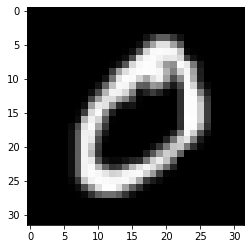

In [143]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(example_data[0][0],cmap='gray',interpolation = 'none')

In [155]:
net = Net()
#print(net)
data = torch.randn(1, 1, 32, 32)
data = example_data
print(data.size())
out = net(data)
print(target)



loss = nn.CrossEntropyLoss()
output = loss(out,example_target)
print(output)

torch.Size([1, 1, 32, 32])
torch.Size([1, 64, 16, 16])
torch.Size([1, 128, 8, 8])
torch.Size([1, 256, 8, 8])
torch.Size([1, 256, 4, 4])
torch.Size([1, 512, 4, 4])
torch.Size([1, 512, 2, 2])
torch.Size([1, 512, 2, 2])
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 10])
tensor([1])
tensor(1.8833, grad_fn=<NllLossBackward>)
